# Wine quality prediction with a Dense Network (DNN)

## Objectives  :
- Predict the quality of wines, based on their analysis
- Understanting the principal and the architecture of a regression with a dense neural network with backup and restore of the trained model.

The Wine Quality datasets are made up of analyses of a large number of wines, with an associated quality (betwenn 0 and 10).
This dataset is provide by :
Paulo Cortez, University of Minho, Guimaräes, Portugal


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

2024-02-12 08:25:58.007622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Step 2 - Retrieve data

In [2]:
data = pd.read_csv('winequality-red.csv', header =0, sep=';')
display(data.head(5).style.format("{0:.2f}"))
print ('Missing Data:',data.isna().sum().sum(), ' Shape is:', data.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5.00
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5.00
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6.00
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5.00


Missing Data: 0  Shape is: (1599, 12)


# Step 3 - Preparing the data

## 3.1 - Split data

We will use 80% of the data for training and 20% for validation.
x will be the data of the analysis and y the quality.

In [4]:
# ------ split => train, test
data = data.sample(frac=1., axis=0)
data_train = data.sample(frac=0.8, axis=0)
data_test = data.drop(data_train.index)

# ------ split => x, y (y is quality)
x_train = data_train.drop('quality', axis=1)
y_train = data_train['quality']
x_test = data_test.drop('quality', axis=1)
y_test = data_test['quality']

print ('Original data shape was:', data.shape)
print ('x_train:', x_train.shape, ' y_train:', y_train.shape)
print ('x_test:', x_test.shape, ' y_test:', y_test.shape)

Original data shape was: (1599, 12)
x_train: (1279, 11)  y_train: (1279,)
x_test: (320, 11)  y_test: (320,)


## 3.2 - Data normalization

Note :

- All input data muste be normalized, train and test.
- To do this we will subtract the mean and divide by the standard deviation.
- But test data should not be used in any way, even for normalization.
- The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before Normalization : "))

mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After Normalization : "))

# Convert ou DataFrame to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.33,0.53,0.27,2.54,0.09,15.73,45.97,1.00,3.31,0.66,10.42
std,1.75,0.18,0.19,1.39,0.05,10.43,32.17,0.00,0.16,0.18,1.07
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40
25%,7.10,0.39,0.10,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50
50%,7.90,0.52,0.26,2.20,0.08,13.00,37.00,1.00,3.31,0.62,10.20
75%,9.30,0.64,0.43,2.60,0.09,21.00,62.00,1.00,3.40,0.74,11.03
max,15.90,1.58,1.00,15.50,0.61,72.00,165.00,1.00,4.01,2.00,14.90


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.13,-2.26,-1.40,-1.17,-1.59,-1.41,-1.24,-3.56,-3.66,-1.88,-1.88
25%,-0.70,-0.76,-0.89,-0.46,-0.36,-0.84,-0.75,-0.60,-0.64,-0.63,-0.85
50%,-0.25,-0.04,-0.07,-0.24,-0.17,-0.26,-0.28,0.03,0.00,-0.24,-0.20
75%,0.56,0.63,0.81,0.05,0.06,0.51,0.50,0.56,0.58,0.44,0.58
max,4.33,5.85,3.74,9.30,11.10,5.39,3.70,3.71,4.50,7.55,4.18


# Step 4 - Build a model

In [6]:
def get_model_v1(shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=shape, name='InputLayer'))
    model.add(tf.keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(tf.keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(tf.keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'mse'])
    return model    

# Step 5 - Train the model 

## 5.1 - Get it 

In [7]:
model = get_model_v1((11,))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4993 (19.50 KB)
Trainable params: 4993 (19.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 5.2 - Add callback

In [8]:
os.makedirs('./run/models', mode=0o750, exist_ok=True)
save_dir = './run/models/best_model.h5'

savemodel = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

## 5.3 - Train it

In [9]:
history = model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), callbacks=[savemodel], verbose=0)

/Users/jules/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Step 6 - Evaluate

## 6.1 - Model evaluation 

MAE = Mean Absolute Error (between the labels and predictions)
A MAE equal to 3 represents an average error in prdection of $3K.

In [10]:
scrore = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss : {:5.4f} '.format(scrore[0]))
print('x_test / mae : {:5.4f} '.format(scrore[1]))
print('x_test / mse : {:5.4f} '.format(scrore[2]))

x_test / loss : 0.4341 
x_test / mae : 0.4808 
x_test / mse : 0.4341 


## 6.2 - Training history

What was the best result during our training?

In [11]:
print("min(val_mae) : {:.4f}".format(min(history.history['val_mae'])))

min(val_mae) : 0.4525


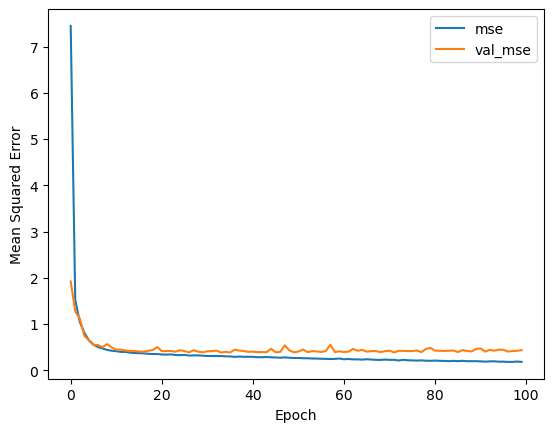

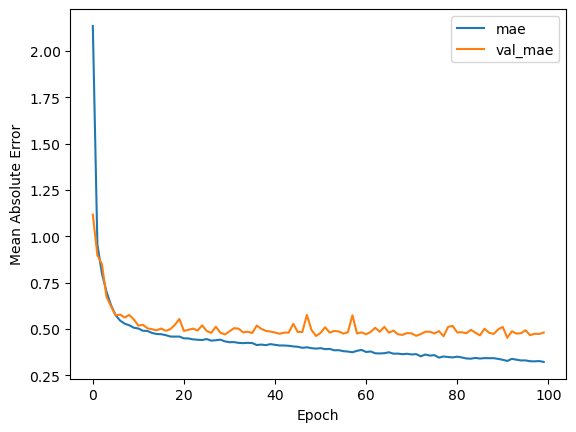

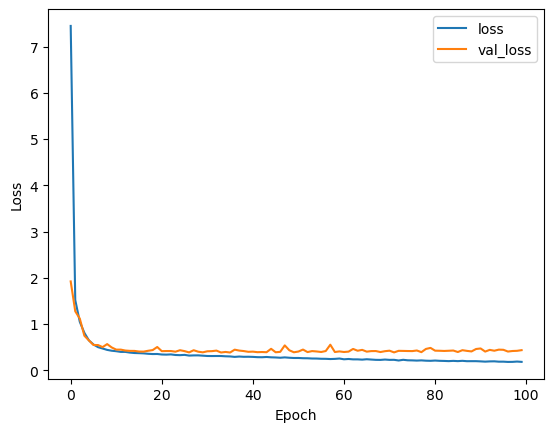

In [12]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 7 - Restore a model :

## 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                768       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4993 (19.50 KB)
Trainable params: 4993 (19.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Loaded.


## 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss : {:5.4f} '.format(score[0]))
print('x_test / mae : {:5.4f} '.format(score[1]))
print('x_test / mse : {:5.4f} '.format(score[2]))

x_test / loss : 0.3830 
x_test / mae : 0.4780 
x_test / mse : 0.3830 


## 7.3 - Make a prediction

In [15]:
# ------ Pick n entries from our test set
n = 200
ii = np.random.randint(1, len(x_test), n)
x_sample = x_test[ii]
y_sample = y_test[ii]

In [16]:
# ------ Make a prediction
y_pred = loaded_model.predict(x_sample, verbose=2)

7/7 - 0s - 88ms/epoch - 13ms/step


In [17]:
# ------ Show it
print('Wine Prediction Real Delta ')
for i in range(n):
    pred = y_pred[i][0]
    real = y_sample[i]
    delta = real - pred
    print(f'{i:03d} {pred:.2f} {real} {delta:.2f}')


Wine Prediction Real Delta 
000 5.36 5 -0.36
001 5.49 5 -0.49
002 6.23 5 -1.23
003 5.11 5 -0.11
004 5.11 5 -0.11
005 5.15 5 -0.15
006 6.04 6 -0.04
007 5.54 6 0.46
008 5.71 7 1.29
009 5.17 5 -0.17
010 5.21 5 -0.21
011 5.52 7 1.48
012 5.61 6 0.39
013 5.79 6 0.21
014 5.71 6 0.29
015 6.03 6 -0.03
016 6.19 7 0.81
017 5.54 5 -0.54
018 4.93 5 0.07
019 5.05 5 -0.05
020 5.67 5 -0.67
021 5.74 6 0.26
022 5.68 5 -0.68
023 6.34 7 0.66
024 5.44 5 -0.44
025 4.81 5 0.19
026 5.44 5 -0.44
027 6.80 7 0.20
028 4.93 5 0.07
029 5.95 6 0.05
030 5.89 5 -0.89
031 5.06 5 -0.06
032 5.83 6 0.17
033 5.02 6 0.98
034 6.12 6 -0.12
035 4.97 5 0.03
036 6.41 7 0.59
037 5.54 6 0.46
038 6.56 6 -0.56
039 5.88 6 0.12
040 6.21 6 -0.21
041 6.02 6 -0.02
042 6.50 6 -0.50
043 5.20 6 0.80
044 5.52 5 -0.52
045 5.12 5 -0.12
046 6.12 6 -0.12
047 6.10 4 -2.10
048 5.12 5 -0.12
049 7.06 7 -0.06
050 4.85 3 -1.85
051 5.84 6 0.16
052 4.52 4 -0.52
053 5.36 5 -0.36
054 5.07 5 -0.07
055 6.87 7 0.13
056 5.20 5 -0.20
057 5.03 5 -0.03
058 5.49 